# Классификация текста

## Cодержание
- [Data preprocessing](#Data-preprocessing)
- [Embeddings](#Embeddings)
- [Dataloader](#Dataloader)
- [CNN](#CNN)

In [96]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
os.chdir('../../')

In [154]:
class Experiment:
    
    def __init__(self):
        self.metrics = []
        
    def add_metrics(self, metrics: dict):
        self.metrics.append(metrics)
    
    

class Logger:
    
    def __init__(self):
        self.experiments = {}
        self.exp_name = None
        
    def init(self, name: str):
        self.experiments.update({
            name: Experiment()
        })
        self.exp_name = name
    
    def log(self, metrics: dict):
        if self.exp_name is None:
            raise Exception("Требуется инициализация эксперимента")
        self.experiments.get(self.exp_name).add_metrics(metrics)
        
        
logger = Logger()

## Data preprocessing

In [31]:
base_data_path = 'data/datasets/ag_news'

train_data_path = os.path.join(base_data_path, 'ag_news_train.csv')
test_data_path = os.path.join(base_data_path, 'ag_news_test.csv')

In [38]:
train_data = pd.read_csv(train_data_path, sep='\t')
test_data = pd.read_csv(test_data_path, sep='\t')

In [40]:
train_corpus = train_data.text
test_corpus = test_data.text

In [41]:
train_labels = train_data['label']
test_labels = test_data['label']

In [42]:
print(f"train sise: {len(train_data)}")
print(f"test size: {len(test_data)}")

train sise: 120000
test size: 7600


In [44]:
def tokenize_text(texts):
    return [re.findall(r'\w+', text.lower()) for text in tqdm(texts)]

train_data_tokenized = tokenize_text(train_corpus)
test_data_tokenized = tokenize_text(test_corpus)

100%|███████████████████████████████████| 7600/7600 [00:00<00:00, 107241.61it/s]


In [51]:
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [
        [word for word in words if word not in stop_words]
        for words in tqdm(texts)
    ]

train_data_tokenized = remove_stopwords(train_data_tokenized)
test_data_tokenized = remove_stopwords(test_data_tokenized)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 13382.40it/s]


In [55]:
def lemmatize_text(texts):
    lemmatizer = WordNetLemmatizer()
    return [
        [lemmatizer.lemmatize(word) for word in words]
        for words in tqdm(texts)
    ]

train_data_lemmatized = lemmatize_text(train_data_tokenized)
test_data_lemmatized = lemmatize_text(test_data_tokenized)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 11742.56it/s]


## Embeddings

In [61]:
w2v_model = Word2Vec(
    train_data_lemmatized,
    vector_size=100,
    min_count=5,
    window=5
).wv

In [63]:
def encode_dataset(dataset):
    encoded = []
    for words in tqdm(dataset):
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))
    return encoded

train_embeddings = encode_dataset(train_data_lemmatized)
test_embeddings = encode_dataset(test_data_lemmatized)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 24564.54it/s]


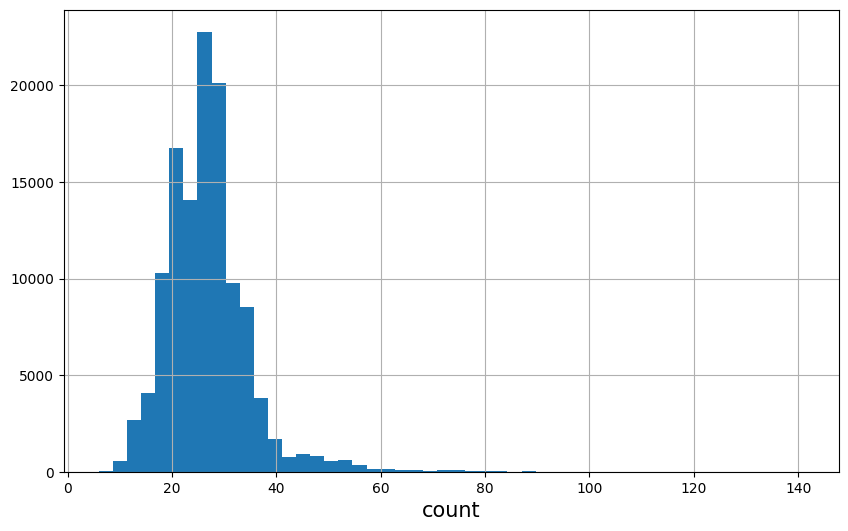

In [65]:
text_lens = [len(x) for x in train_embeddings]

plt.figure(figsize=(10, 6))
plt.hist(text_lens, bins=50)
plt.xlabel("text length", size=15)
plt.xlabel("count", size=15)
plt.grid()
plt.show()

## Dataloader

In [146]:
train_dataset = list(zip(train_embeddings, train_labels))
test_dataset = list(zip(test_embeddings, test_labels))

In [147]:
def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)

In [148]:
w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

In [94]:
batch = next(iter(w2v_train_loader))
print(batch[0].shape)
batch

torch.Size([32, 43, 100])


(tensor([[[ 1.2251e-01,  7.8375e-01,  1.5363e+00,  ..., -1.0553e+00,
           -7.1905e-01,  1.0314e+00],
          [-7.7629e-02,  1.0159e-01,  8.5800e-03,  ..., -5.6378e-02,
            3.9943e-02,  5.8541e-02],
          [ 1.7985e-01, -1.5852e-01, -1.2184e+00,  ..., -1.7781e+00,
            4.5035e-01, -2.1412e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-1.8108e-02,  6.5831e-02,  4.8880e-01,  ..., -9.6514e-02,
            9.5142e-01,  4.6532e-01],
          [ 2.7291e-01, -5.8471e-01, -1.7775e+00,  ...,  1.0767e-01,
            5.4018e-01,  6.5280e-01],
          [-2.5151e-01, -3.7193e-01,  2.2805e-01,  ..., -3.7696e-01,
           -1.2132e+00,  1.6046e+00],
          ...,
    

## CNN

In [130]:
class SimpleCNN(nn.Module):
    
    def __init__(self, hid_dim=100, n_classes=4):
        super().__init__()
        
        self.conv1 = nn.Conv1d(
            in_channels=hid_dim,
            out_channels=hid_dim,
            kernel_size=3,
            stride=1,
            padding=0
        )
        
        self.conv2 = nn.Conv1d(
            in_channels=hid_dim,
            out_channels=hid_dim,
            kernel_size=3,
            stride=1,
            padding=0
        )
        self.fc = nn.Linear(
            in_features=hid_dim,
            out_features=n_classes
        )
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor):
    
        # [batch_size, seq_len, dim] -> [batch_size, dim, seq_len]
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)
        
        x = self.fc(x)
        return x
    
model = SimpleCNN()
model(batch[0])

tensor([[ 0.0348,  0.0336,  0.0802,  0.2069],
        [-0.0738, -0.0078,  0.2268,  0.3623],
        [-0.0021,  0.0531,  0.1772,  0.4460],
        [ 0.1414, -0.0027,  0.1635,  0.4954],
        [-0.0529, -0.0018,  0.1422,  0.3442],
        [-0.0157,  0.0317,  0.3764,  0.3208],
        [ 0.0894, -0.0551,  0.1475,  0.4378],
        [-0.1362, -0.0408,  0.3113,  0.3071],
        [ 0.0403,  0.0174,  0.1700,  0.4209],
        [-0.0788,  0.0264,  0.2748,  0.4453],
        [ 0.1287,  0.0759,  0.1961,  0.3482],
        [ 0.0303, -0.0008,  0.1938,  0.2976],
        [-0.0226, -0.0719,  0.1787,  0.4252],
        [-0.0492, -0.0311,  0.2592,  0.4568],
        [ 0.0261, -0.0182,  0.3123,  0.4195],
        [ 0.0989, -0.0512,  0.1744,  0.3885],
        [ 0.0313, -0.0272,  0.2904,  0.5103],
        [ 0.0554, -0.1083,  0.1730,  0.3183],
        [ 0.2112, -0.1009,  0.1005,  0.3412],
        [ 0.1469,  0.0874,  0.1861,  0.3506],
        [ 0.0303,  0.0277,  0.1732,  0.4212],
        [ 0.0907,  0.0022,  0.2699

In [165]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer
):
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    correct = []
    losses = []
    
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        logits = model(tokens)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct.extend((logits.argmax(-1) == labels).float().cpu())
        losses.append(loss.item())
        
    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)
    
    logger.log({
        "train_loss": loss.item(),
        "train_accuracy": accuracy
    })
        

@torch.inference_mode()
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader
):
    
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    correct = []
    losses = []
    
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        logits = model(tokens)
        loss = criterion(logits, labels)
        
        correct.extend((logits.argmax(-1) == labels).float().cpu())
        losses.append(loss.item())
        
    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)
    
    logger.log({
        "test_loss": mean_loss,
        "test_accuracy": accuracy
    })

In [155]:
logger.init("SimpleCNN")

In [166]:
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e3
)

In [167]:
for epoch in tqdm(range(5)):
    train(model, w2v_train_loader, optimizer)
    evaluate(model, w2v_test_loader)

100%|████████████████████████████████████████████| 5/5 [09:16<00:00, 111.24s/it]


[К содержанию](#Cодержание)